In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import admix_prs

import xarray as xr
import pandas as pd
import numpy as np

import admix
from scipy import stats
import matplotlib.pyplot as plt
from os.path import join
from tqdm import tqdm

In [2]:
WEIGHTS_DIR = f"../../data/prs/weights/"
PLINK_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/admix-prs-uncertainty/data/PLINK/"
group_list = ["eur_test", "admix"]
bfile_list = [join(PLINK_DIR, group, "merged") for group in group_list]

In [5]:
def submit_predict(trait):

    df_weights = (
        pd.read_csv(join(WEIGHTS_DIR, trait, "beta.tsv.gz"), sep="\t")
        .rename(columns={"CHR": "CHROM", "A1": "REF", "A2": "ALT"})
        .set_index("SNP")
    )

    for group, bfile in zip(group_list, bfile_list):
        df_pred = admix_prs.calc_prs(bfile, df_weights)
        df_pred.to_csv(f"out/prs/{trait}.{group}.tsv.gz", sep="\t")


import submitit

executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=70,
    memory_g=20,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
    ],
)

jobs = executor.map_array(submit_predict, ["height"])

In [6]:
df_lanc = pd.read_csv("../02_simulation/out/admix_lanc.tsv", sep="\t", index_col=0)
df_lanc["lanc"] = 1.0 - df_lanc["lanc"]
df_lanc["lanc_q"] = pd.qcut(df_lanc.lanc, q=5).cat.codes + 1

In [8]:
trait = "height"

In [44]:
df_pheno = []
for group in ["eur_test", "admix"]:
    df_tmp = pd.read_csv(
        join(f"../../data/pheno/{group}.{trait}.residual_pheno"), sep="\t"
    ).rename(columns={f"{trait}-residual": trait})
    df_tmp.index = df_tmp.FID.astype(str) + "_" + df_tmp.IID.astype(str)
    df_tmp = df_tmp.drop(columns=["FID", "IID"])
    df_pheno.append(df_tmp)
df_pheno = (
    pd.concat(df_pheno)
    .reset_index()
    .drop_duplicates(subset=["index"])
    .set_index("index")
)

In [69]:
df_prs_eur_test = pd.read_csv(f"out/prs/{trait}.eur_test.tsv.gz", sep="\t", index_col=0)
df_prs_eur_test["GROUP"] = "eur_test"
df_prs_admix = pd.read_csv(f"out/prs/{trait}.admix.tsv.gz", sep="\t", index_col=0)
df_prs_admix["GROUP"] = "admix"
df_prs = pd.concat([df_prs_eur_test, df_prs_admix])
df_prs["PHENO"] = df_pheno[trait].reindex(df_prs.index)

QUANTILES = [0.1, 0.9]
pred_interval = np.quantile(
    df_prs[[f"SAMPLE_{i}" for i in range(1, 501)]], q=QUANTILES, axis=1
)
pred_sd = np.std(df_prs[[f"SAMPLE_{i}" for i in range(1, 501)]], axis=1)
df_plot = pd.DataFrame(
    {
        "PRS_MEAN": df_prs["MEAN"],
        "PRS_SD": pred_sd,
        "GROUP": df_prs["GROUP"],
        "PHENO": df_prs["PHENO"],
    }
)
df_plot = df_plot[df_plot.GROUP == "eur_test"]
# for q_i, q in enumerate(QUANTILES):
#     df_plot[f"PRS_Q_{q}"] = pred_interval[q_i, :]

# intercept = df_plot.GV.mean() - df_plot["PRS_MEAN"].mean()
# for col in [col for col in df_plot.columns if col.startswith("PRS_")]:
#     if col == "PRS_SD":
#         continue
#     df_plot[col] += intercept

In [70]:
df_plot = df_plot.dropna()

In [72]:
stats.pearsonr(df_plot["PRS_MEAN"], df_plot["PHENO"])

(0.5630297293051163, 0.0)

In [61]:
df_plot["lanc"] = df_lanc["lanc"].reindex(df_plot.index)
df_plot["lanc_q"] = df_lanc["lanc_q"].reindex(df_plot.index)

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5')]

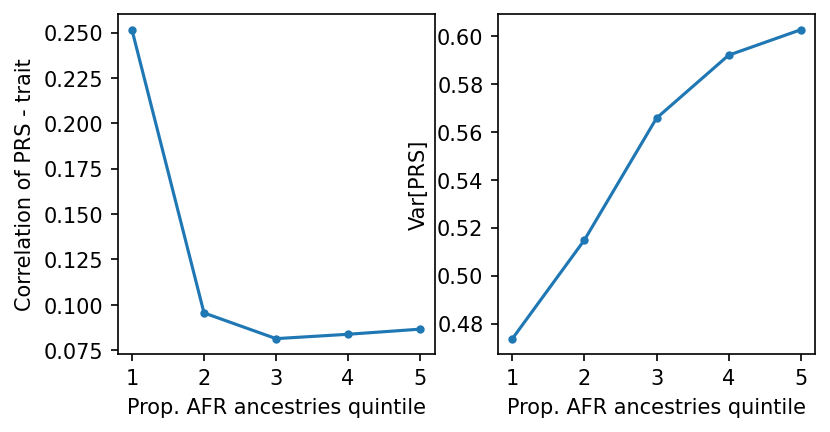

In [67]:
df_plot_group = {"group": [], "R2": [], "avg_prs_sd": []}

for i, group in df_plot.groupby("lanc_q"):
    df_plot_group["group"].append(i)
    df_plot_group["R2"].append(
        stats.pearsonr(group["PRS_MEAN"], group["PHENO"])[0] ** 2
    )
    df_plot_group["avg_prs_sd"].append(group["PRS_SD"].mean())

fig, axes = plt.subplots(figsize=(6, 3), ncols=2, dpi=150)
xticks = np.arange(len(df_plot_group["group"]))
axes[0].plot(np.arange(len(df_plot_group["group"])), df_plot_group["R2"], ".-")
axes[0].set_xlabel("Prop. AFR ancestries quintile")
axes[0].set_ylabel("Correlation of PRS - trait")
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks + 1)

axes[1].plot(np.arange(len(df_plot_group["group"])), df_plot_group["avg_prs_sd"], ".-")
axes[1].set_xlabel("Prop. AFR ancestries quintile")
axes[1].set_ylabel("Var[PRS]")
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks + 1)

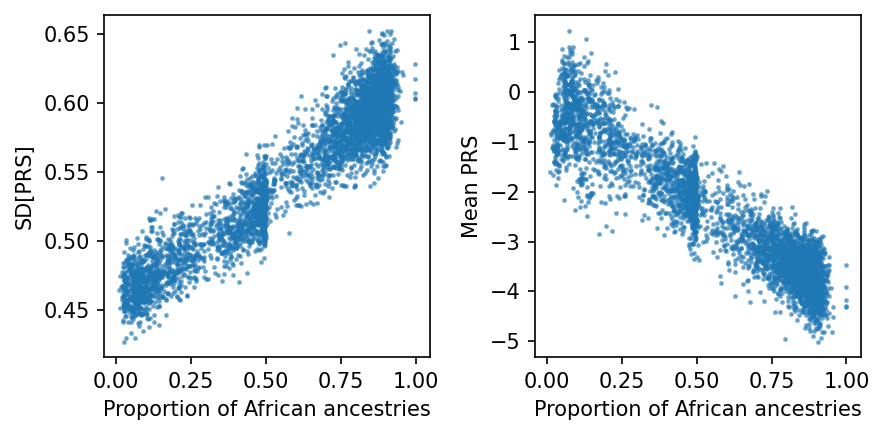

In [58]:
fig, axes = plt.subplots(dpi=150, figsize=(6, 3), ncols=2)

# uncertainty ~ AFR ancestries
ax = axes[0]
ax.scatter(df_plot["lanc"], df_plot["PRS_SD"], s=2, alpha=0.5)
ax.set_xlabel("Proportion of African ancestries")
ax.set_ylabel("SD[PRS]")

# PRS ~ AFR ancestries
ax = axes[1]
ax.scatter(df_plot["lanc"], df_plot["PRS_MEAN"], s=2, alpha=0.5)
ax.set_xlabel("Proportion of African ancestries")
ax.set_ylabel("Mean PRS")

fig.tight_layout()

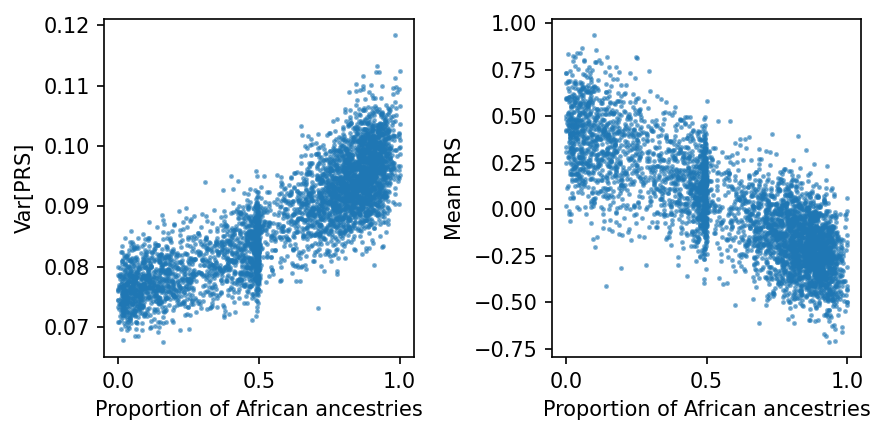

In [13]:
fig, axes = plt.subplots(dpi=150, figsize=(6,3), ncols=2)

# uncertainty ~ AFR ancestries
ax = axes[0]
ax.scatter(1. - dset["avg_lanc"], dset["height_prs_var"], s=2, alpha=0.5)
ax.set_xlabel("Proportion of African ancestries")
ax.set_ylabel("Var[PRS]")

# PRS ~ AFR ancestries
ax = axes[1]
ax.scatter(1. - dset["avg_lanc"], dset["height_prs_mean"], s=2, alpha=0.5)
ax.set_xlabel("Proportion of African ancestries")
ax.set_ylabel("Mean PRS")

fig.tight_layout()

In [14]:
df_plot = dset[["height", "avg_lanc", "height_prs_mean", "height_prs_var"]].to_dataframe().dropna(how="any")

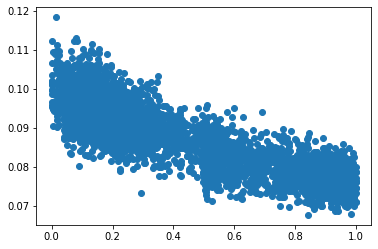

In [15]:
plt.scatter(df_plot["avg_lanc"], df_plot["height_prs_var"])

In [16]:
df_plot["avg_lanc_bin"] = pd.qcut(1. - df_plot["avg_lanc"], q=5)

In [17]:
df_plot_group = {
    "group": [],
    "R2": [],
    "avg_prs_var": []
}

for i, group in df_plot.groupby("avg_lanc_bin"):
    df_plot_group["group"].append(i)
    df_plot_group["R2"].append(stats.pearsonr(group["height"], group["height_prs_mean"])[0] ** 2)
    df_plot_group["avg_prs_var"].append(group["height_prs_var"].mean())  

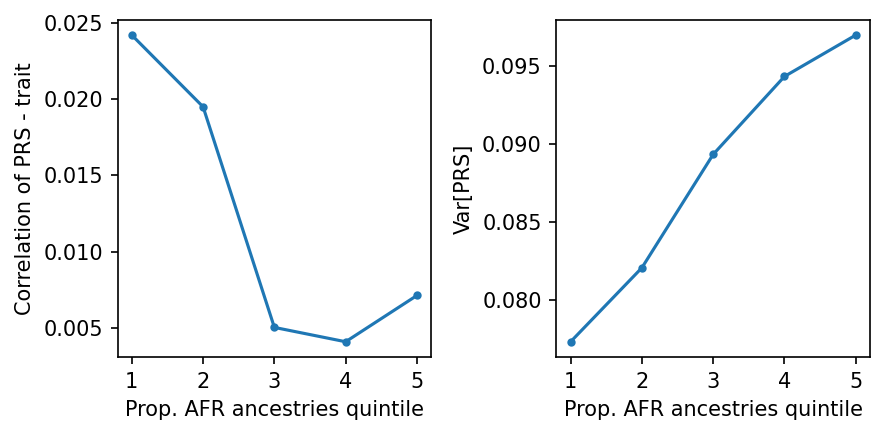

In [18]:
fig, axes = plt.subplots(figsize=(6, 3), ncols=2, dpi=150)
xticks = np.arange(len(df_plot_group["group"]))
axes[0].plot(np.arange(len(df_plot_group["group"])), df_plot_group["R2"], '.-')
axes[0].set_xlabel("Prop. AFR ancestries quintile")
axes[0].set_ylabel("Correlation of PRS - trait")
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks + 1)

axes[1].plot(np.arange(len(df_plot_group["group"])), df_plot_group["avg_prs_var"], '.-')
axes[1].set_xlabel("Prop. AFR ancestries quintile")
axes[1].set_ylabel("Var[PRS]")
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks + 1)

fig.tight_layout()